In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x43_DEFG106015.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.690620,-0.103500,-0.682209,1.854891,1.854891,-0.574055,-0.679754,-0.276345,-0.783764,-0.496737,1.184192,0.348674,-0.297219,-0.073736,-0.143169,-0.449502,-0.863385,-0.264331,1.418637,-0.044854,0.526933,-0.508471,-0.035348,-0.770135,-0.36308,0.980229,-0.130079,-0.21583,-0.750379,3.423387,-0.155841,-0.19835,-0.207244,-0.222089,-0.567743,-0.070829,-0.262525,-0.170615,-0.093874,-0.595928,1.211682,-0.706225,0.0
1,-0.955504,-0.262801,1.299299,0.100205,0.100205,0.610194,-0.891312,-0.678850,-0.869800,-0.391403,0.423220,-0.462761,-0.890405,-0.073736,-0.143169,-0.449502,0.330701,-0.264331,1.418637,1.320058,1.482247,-1.575572,-0.035348,1.298474,-0.36308,-1.020170,-0.130079,-0.21583,1.332660,-0.292108,-0.155841,-0.19835,-0.207244,-0.222089,-0.567743,-0.070829,-0.262525,-0.170615,-0.093874,-0.595928,1.211682,-0.706225,0.0
2,0.909279,-0.020386,-0.886591,1.102883,1.102883,1.790152,1.154561,-0.276345,-0.869800,-0.232688,-1.098725,-0.462761,-0.890405,-0.073736,-0.143169,-0.449502,-1.399505,-0.264331,1.418637,2.684969,2.437561,-0.508471,-0.035348,-0.770135,-0.36308,0.980229,-0.130079,-0.21583,-0.750379,-0.292108,-0.155841,-0.19835,-0.207244,-0.222089,-0.567743,-0.070829,3.809157,-0.170615,-0.093874,-0.595928,1.211682,-0.706225,1.0
3,1.587382,0.118138,0.606394,0.100205,0.100205,-0.784302,1.556920,-0.276345,-0.353589,-0.235068,-1.098725,-0.462761,1.254190,-0.073736,-0.143169,3.503923,-0.424741,-0.264331,1.418637,-0.044854,0.526933,-1.575572,-0.035348,-0.770135,-0.36308,0.980229,-0.130079,-0.21583,1.332660,-0.292108,-0.155841,-0.19835,-0.207244,-0.222089,-0.567743,-0.070829,-0.262525,-0.170615,-0.093874,-0.595928,1.211682,-0.706225,1.0
4,-0.944908,-0.228171,0.097932,-0.651803,-0.651803,-0.784302,-0.941371,0.729917,0.764868,-0.022852,0.423220,-0.462761,-0.890405,-0.073736,-0.143169,-0.449502,-0.607509,-0.264331,1.418637,-0.044854,0.526933,-1.042021,-0.035348,1.298474,-0.36308,-1.020170,-0.130079,-0.21583,1.332660,-0.292108,-0.155841,-0.19835,-0.207244,-0.222089,-0.567743,-0.070829,-0.262525,-0.170615,-0.093874,-0.595928,1.211682,-0.706225,1.0


In [4]:
data.shape

(2404, 43)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    1868
0.0     536
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(2404, 42)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77338877 0.77130977 0.78170478 0.77546778 0.77083333]
0.7745408870408871


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  23,  513],
       [  29, 1839]])

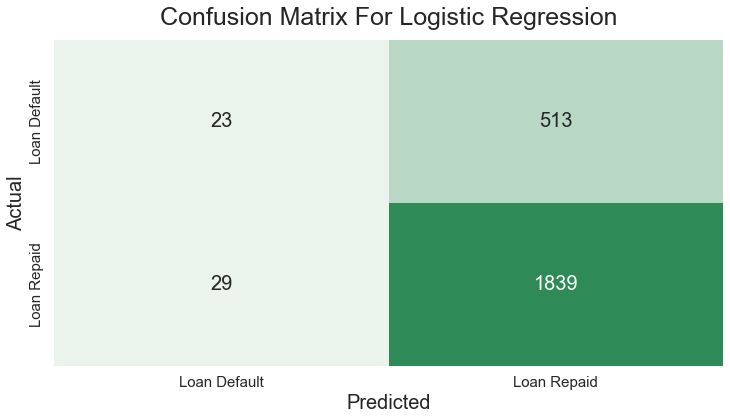

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.7745424292845258

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

1839
513
29
23
0.7745424292845258


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    1868
0.0     536
Name: loan_status_bin, dtype: int64

0.7770382695507487


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 0.1% better than Null Model or "random investment"
TP / (TP+FP)

0.7818877551020408

In [17]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [18]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [19]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [20]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77338877 0.77130977 0.78170478 0.77546778 0.77083333]
0.7745408870408871


In [21]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  23,  513],
       [  29, 1839]])

In [22]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [23]:
y_pred_prob

array([[0.31927015, 0.68072985],
       [0.28328262, 0.71671738],
       [0.56841317, 0.43158683],
       ...,
       [0.15235062, 0.84764938],
       [0.29292945, 0.70707055],
       [0.16672735, 0.83327265]])

In [62]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.84).astype('float')
y_pred_success

array([0., 0., 0., ..., 1., 0., 0.])

In [63]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 428,  108],
       [1161,  707]])

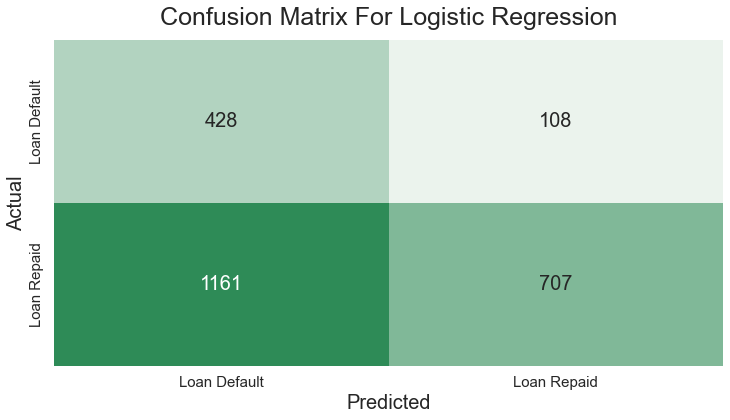

In [64]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [65]:
accuracy_score(y, y_pred_success)

0.4721297836938436

In [66]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

707
108
1161
428
0.4721297836938436


In [67]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8674846625766871

In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 